In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import g, R
from scipy.integrate import solve_ivp
from typhon.physics import e_eq_water_mk as saturation_pressure

plt.rcParams.update({'font.size': 12})

### some constants
mr_water     = 0.01801528        # molecular mass of water
mr_dry       = 0.0289647         # molecular mass (per 1 mole) of dry air (M_r)                 
mr_ratio     = mr_water/mr_dry
rgas_dry     = R/mr_dry          # specific gas constant for dry air [J/Kg/K]      <-- used in ideal gas equation for hydrostsic rather than moist??
rgas_v       = R/mr_water        # specific gas constant for water
cp_dry       = 1004.9            # specific heat capacity (dry) air at const. pressure [J/Kg/K] (taken at 300K)   = 1.400*cv_dry 
cp_v         = 1864              # specific heat capacity of water vapour [J/Kg/K] (at 300K)
c_l          = 4180              # specific heat capacity of liquid water[J/Kg/K] (at 300K)
rho_dry      = 1.177             # density of dry air [Kg/m^3] (at 300K)
latent_v     = 2437300           # specific latent heat of vapourisation of water [J/Kg]  (at 300K)
rho_l        = 996.57            # density of liquid water condensing [kg/m^3] (at 300K)
### NOTE! temperature depedence of cp and latent_v ignored
### NOTE! Heat content of condensed water ignored

In [2]:

def pv2qv(pv, p):
    ''' calculate mass mixing ratio
    qv = m_v/m_dry =rho_v/rho_dry
    given vapour pressure pv = p_v/p_tot '''
    
    qv = mr_ratio * pv/(p-pv)
    
    return qv

def qv2pv(qv, p):
    ''' calculate vapour pressure
    pv = p_v/p_tot
    given mass mixing ratio 
    qv = m_v/m_dry = rho_v/rho_dry'''
    
    pv = p*qv/(mr_ratio+qv)
    
    return pv


def cp_moist(qv, qc):
    ''' calculate effecitve specific heat 
    capacity of parcel with water vapour 
    qv=m_v/m_dry and liquid water qc= m_l/m_dry
    (notice m_dry not m_tot). Enthalpy change of
    parcel per unit (total) mass = dh. 
    (1+qv+qc)dh = cp_eff*dtemp + latent_v*dqv'''

    return cp_dry + cp_v*qv + c_l*qc 
 

def dry_pot_temp(temp, p, qv):
    ''' calculate potential temperature
    assuming moist (unsaturated) air with
    vapour content qv '''
    
    cp = cp_dry * (1+qv*cp_v/cp_dry)/(1+qv)
    rgas = rgas_dry *(1+qv*rgas_v/rgas_dry)/(1+qv)
    
    theta = temp*(p[0]/p)**(rgas/cp)
    
    return theta


def raxes4dists(ax, lnr, eps, edgs):
    ''' axes labels, ticks etc. for lognormal
    radius distribution plots'''
     
    ax1 = ax.twiny()
    linear_wdths = np.e**edgs[1:] - np.e**edgs[:-1]
    ax1.bar(np.e**lnr*1e6, eps, linear_wdths*1e6, alpha=0)
    ax1.set_xscale('log')
    ax1.set_xlabel('radius, r /\u03BCm)')
    
    ax.set_xlabel('ln(r /\u03BCm)')
    ax.set_ylabel('No. concentration of droplets [m$^{-3}$]')
  
    return ax, ax1

In [3]:
### initial parcel conditions
w               = 0.5                                             # vertical wind speed [m/s] (dP/dt = w*dP/dz)
z0              = 0                                             # initial z coordinate
temp0, p0       = 273.15, 100000                                # initial temp & pressure
relh0           = 60                                            # initial relative humidity (%)
qc0             = 0                                             # initial liquid water content
cond            = True



### droplet properties (see droplet initialisation for more parameters)
mus             = [0.2e-6, 0.015e-6]                # [m] geometric mean droplet radius
sigs            = [1.5, 1.6]                        # geometric std. dev.
n_as            = [0.75e6, 0.25e6]                  # [m^-3] total no. concentration of droplets
rspan           = [1e-9, 1e-5]                      # initial range of droplet radii [m]
nbins           = 50                                # no. of different initial radii (evenly spaced between ln(rspan))

mr_sol         = 0.058443                           # Mr of solute (dry areosol) [Kg/mol]
ionic          = 2                                  # degree ionic dissociation (van't Hoff factor)
rho_sol        = 2200                               # density of dry areosol [Kg m^-3]



# integration params
tspan          = [0, 6000]
t_eval         = np.linspace(tspan[0], tspan[1], 100)
method         = 'LSODA'
maxtstep       = 0.1 
rtol           = 1e-6                           # relative tolerance (tol) for integration
atol           = [1e-6]*5+[1e-9]                # absolute tols for [z,temp, p,qv,qc] and [droplet radii]

### resulting values of some variables
pv0 = relh0/100 * saturation_pressure(temp0)     # initial water vapour pressure
qv0 = pv2qv(pv0, p0)                             # initial water mass mixing ratio (mass water/mass dry air)



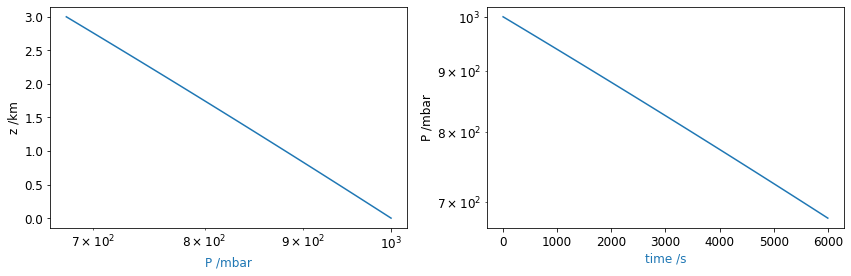

In [4]:
def dp_dz_profile(z, pprofile=False):
    '''pressure profile used for pressure change 
    of parcel over time (dP/dt = dP/dz * dz/dt.
    Here, dp/dz is chosen to be that for a dry
    hydrostatic atmosphere with constant lapse rate '''

    pg, zg = 100000, 0
    lps_rate, tempg = 0.0062, 273.15
    profile = 1 - lps_rate/tempg*(z-zg)
    temp_surr = tempg*profile
    p_surr = pg * profile**(g/(rgas_dry*lps_rate))
    
    if pprofile:
        return p_surr
    else:
        dp_dz = -g*p_surr/(rgas_dry*temp_surr)      
        return dp_dz


zplt = z0+w*t_eval
pplt = dp_dz_profile(zplt, pprofile=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axs = axs.flatten()

def axplt(ax,x,y,xlab=None,ylab=None, lab=None, i=0):
    ax.plot(x,y, label=lab, color='C'+str(i))
    ax.set_xlabel(xlab, color='C'+str(i))
    ax.set_ylabel(ylab)

axplt(axs[0], pplt/100, zplt/1000, 'P /mbar','z /km', i=0)
axplt(axs[1], t_eval, pplt/100, 'time /s', 'P /mbar', i=0)
axs[0].set_xscale('log')
axs[1].set_yscale('log')

fig.tight_layout()
#plt.close()


In [5]:
class Superdroplets():
    '''Class for all superdroplets, 
    eg. for object drops = Superdroplets(r0) where r0
    is array of drop radii, drops is object with
    radii. multiplicty and other attributes (eg. mass)
    of all superdroplets'''
    
   
    def __init__(self, r, eps, m_sol, mr_sol, ionic, rho_sol, rho_l):
     
        # Common attributes of all superdroplets
        self.rho_l = rho_l                                # density of liquid in droplets (=density of water at 300K) [Kg/m^3]
       
        # droplet solute properties
        self.mr_sol = mr_sol                             # Mr of solute [g/mol]
        self.ionic = ionic                               # degree ionic dissociation (van't Hoff factor)
        self.rho_sol = rho_sol                           # density of dry droplets  (solute density)
        
        # attributes unique to each sperdroplet object
        self.eps = eps                                   # array of multiplicity of droplets
        self.r = r                                       # array of droplet radii
        self.m_sol = m_sol                               # mass of solute dissovled (for each droplet in superdrop) [kg]
        self.dry_r = (3*self.m_sol/(4*np.pi*self.rho_sol))**(1/3)   # dry radius of droplets
        
        self.r0 = r                                      # array of droplet initial radii
        v_w0 = 4/3*np.pi*(self.r0**3 - self.dry_r**3)
        self.m_w0 = self.rho_l*v_w0                      # initial droplet water mass
        self.m0 = self.m_w0 + self.m_sol                 # initial droplet masses
       
    @property
    def m(self):
        ''' total mass of droplet
            (water + dry areosol) '''
        
        addsol = (self.rho_sol - self.rho_l)*(self.dry_r/self.r)**3    #contribution to density due to solute
        rho_eff = self.rho_l + addsol
             
        return  rho_eff*4/3*np.pi*(self.r)**3
    
    @property
    def m_w(self):
        ''' mass of water in droplet '''
        
        v_w = 4/3*np.pi*(self.r**3 - self.dry_r**3)
        
        return self.rho_l*v_w                           # droplet water mass
        
    @property
    def vol(self):
        ''' droplet volume (inc. solute) '''
        
        return 4/3*np.pi*(self.r)**3                     # droplet volume
    
    
    
    def kohler_factors(self, temp):
        ''' calculate b in kelvin factor (1-b/r^3)
        and a in raoult factor (exp^(a/r)) to
        account for curvature and effect of solute
        on radial growth of droplet respectively.
        Using eq.6.24 and eq.6.22 of lohmann, luond
        and mahrt intro 2 clouds textbook'''
        
        # r_activation = sqrt(3b/a)
        # S_activation = 1+sqrt(4a^3/27b)
        a = 3.3e-7/temp                                #2*surface_tens (=0.0756N/m)/(rho_l*rgas_v*temp) [eq.6.24]
        b = 43e-6*self.m_sol*self.ionic/self.mr_sol                   #43e-6 m^3/mol * mass_solute/ Mr_solute [eq.6.22]
            
        return a, b
        
        
    def active(self, s_ratio, temp):
        ''' calculate b in kelvin factor (1-b/r^3)
        and a in raoult factor (exp^(a/r)) to
        account for curvature and effect of solute
        on radial growth of droplet respectively.
        Using eq.6.24 and eq.6.22 of lohmann, luond
        and mahrt intro 2 clouds textbook'''
        
        
        a, b = self.kohler_factors(temp)
       
        r_act = np.sqrt(3*b/a)
        active = np.where(self.r >= r_act, True, False)
        
        return active
         

In [6]:
def lnnormal_dist(r, n_a, mu, sig):
    ''' return number concentration (n [m^-3])
    of particles with radius r in bin of unit length 
    on logarithmic scale based on monomodal 
    lognormal distribution. ie. No particles per cm"^-3
    in bin at radius r of width delta(lnr), n =
    dn_dlnr * delta(lnr)'''
    
    sigtilda = np.log(sig)
    mutilda = np.log(mu)
    norm = n_a/(np.sqrt(2*np.pi)*sigtilda)
    exponent = -(np.log(r)-mutilda)**2/(2*sigtilda**2)
    
    dn_dlnr = norm*np.exp(exponent)                                 # eq.5.8 [lohmann intro 2 clouds]

    return dn_dlnr


def get_lnr_dist(rs, nbins, n_a, mu, sig):
    ''' returns 'nbins' no. of samples from 
    lognormal distribution with even spacing
    in lnr space between ln(r[0]) and ln(rs[1])'''
    
    edgs = np.linspace(np.log(rs[0]), np.log(rs[1]), nbins+1)          # edges to lnr bins
    wdths = edgs[1:]- edgs[:-1]                                      # lnr bin widths
    lnr = (edgs[1:]+edgs[:-1])/2                                     # lnr bin centres
    lnnorm = lnnormal_dist(np.e**lnr, n_a, mu, sig)                  # lognormal values
    
    return lnr, lnnorm, wdths, edgs



def plot_lognormal(eps, lnr, lnnorm, wdths, edgs, pltref=True):
    ''' plots lognormal distribution * bin widths = 
    no. concentration of particles with given radius '''
        
    fig, ax = plt.subplots()
    
    ax.bar(lnr+np.log(1e6), eps, wdths, label='samples')
    
    raxes4dists(ax, lnr, eps, edgs)
    
    if pltref:
        # plot x100 more bins lognormal for reference
        pltlnr, pltnorm, pltwdths = get_lnr_dist(rspan, 
                                nbins*100, n_a, mu, sig)[0:3]
        ax.plot(pltlnr+np.log(1e6), pltnorm*pltwdths*100, 
                    color='k', label='lognormal distribution')
    
    ax.legend()
    plt.tight_layout()
    
    plt.show()

    
    
def radii2dist(data, eps, rs, nbins):
    ''' returns histogram of droplet radii (r) in 
    interval rs[0] t rs[1] in 'nbins' with even 
    spacing in lnr space'''
    
    edgs = np.linspace(np.log(rs[0]), np.log(rs[1]), nbins+1)          # edges to lnr bins
    wdths = edgs[1:]- edgs[:-1]                                      # lnr bin widths
    lnr = (edgs[1:]+edgs[:-1])/2                                     # lnr bin centres
    
    hist, hedgs = np.histogram(np.log(data), bins=edgs, weights=eps)
    
    return hist, wdths, lnr, hedgs


def plot_histogram(ax, data, eps, rspan, nbins, lab=None, c='k'):

    hist, hwdths, hcens, hedgs = radii2dist(data, eps, rspan, nbins)
        
    ax.bar(hcens+np.log(1e6), hist, hwdths, label=lab, color=c)
    
    ax.set_xlabel('ln(r /\u03BCm)')
    ax.set_ylabel('No. concentration of droplets [m$^{-3}$]')
    #ax, ax1 = raxes4dists(ax, hcens, drops.eps, hedgs)
    ax.legend()



In [7]:

### ODE solver
def dtemp_expansion(temp, p, dp, qv, qc):
    ''' calculate dT/dt due to pressure 
    change dp for adiabatic process
    (no heat loss) of parcel that has 
    water vapour mass mixing ratio 
    (m_v/m_dry) = qv and liquid water mass
    mixing ratio (m_c/m_tot) = qc
    Assumes instantaneous volume change 
    of parcel to change pressure according
    to dp_dz profile. '''
    
    pv = qv2pv(qv, p) 
    rho_d = (p-pv)/(rgas_dry*temp)                                    # dry density of parcel (~ total density)
    
    dtemp = 1/cp_moist(qv, qc) * (dp/rho_d)
     
    return dtemp


def diffusion_factors(temp, p, psat):
    ''' calculate Fkl and Fdl heat and vapour
    diffusion factors in equation for 
    radial growth of droplets according to
    eq.7.27 lohmann, luond and mahrt intro 2 
    clouds textbook '''

    # diffusional growth equation factors
    thermk = 4.1868e-3 * (5.69 + 0.017*(temp-273.15))             #[eq.7.24 lohmann intro 2 clouds]
    diffuse_v = 2.11e-5 * (temp/273.15)**1.94 * (101325/p)        #[eq.7.26 lohmann intro 2 clouds]
    
    fkl = (latent_v/(rgas_v*temp) -1)*latent_v/(thermk*temp)
    fdl = rgas_v*temp/(diffuse_v*psat)

    return fkl, fdl


    

def diffusion_growth(drops, temp, p, qv, qc, t):
    ''' diffusion growth of droplets by condensation
    given temperature, pressure and qv.
    NOTE! shrinking by evaporation not includeded, nor
    are ventillation effects fv(r) (see Seifert & stevens 2010)'''
    
    r = drops.r
    
    # supersaturation of parcel
    psat = saturation_pressure(temp)
    s_ratio = qv2pv(qv, p)/psat                                      # ambient supersaturation ratio
        
    a, b = drops.kohler_factors(temp)
       
    # radial growth/shrink of droplets
    fkl, fdl = diffusion_factors(temp, p, psat)                             
    dr = (s_ratio-1 -a/r +b/r**3) / (rho_l * (fkl+fdl) * r)           # [eq.7.27 lohmann intro 2 clouds]
    
    if (r < drops.dry_r).any():                                       # if droplets are dry, do not shrink further
        drydr = np.where(r<drops.dry_r, dr, 0.0)
        dr = np.where(drydr<0.0, 0.0, dr)                  
        drops.r[r<drops.dry_r] = drops.dry_r[r<drops.dry_r]
       
    
    # resultant change to temp, qv and qc of parcel
    dm = rho_l*4*np.pi*(r**2)*dr                                # mass of water condensed onto each drop
    tot_drhov = np.sum(dm*drops.eps)                            # change in density of water in volume
    dqc = tot_drhov/rho_dry
    dqv = -dqc
    dtemp_c = -latent_v/cp_moist(qv, qc) * dqv
    
    
    # have I accounted for solute masses and deliquescence?    


    return dr, dtemp_c, dqv, dqc



def rising_parcel(t, y, w, drops):
    ''' differential equations for rising parcel 
    (thermo)dynamics with condensation onto droplets
    if supersaturation > 0.
    Parcel rises, expands adiabatically and then
    condenses water if qv > q_sat. Rate of condensation
    determined by growth rate of droplets (supersaturation
    is possible if growth slower than rise in relative
    humidity)'''
    
    z, temp, p, qv, qc = y[:5]
    #r = y[5:]
    drops.r = y[5:]

    
    ### dynamics of parcel
    #tau = 50*60                     # tau_w = 50min
    #dz = w*np.sin(2*np.pi*t/tau)
    dz = w
    
    ### thermodynamics of parcel
    # expansion of parcel according to dp_dz profile
    dp = dp_dz_profile(z) * dz
    
    # Temp change solely due to expansion (no condensation)
    dtemp = dtemp_expansion(temp, p, dp, qv, qc)
   
    # condensation (by diffusional growth of droplets)
    if cond:
        dr, dtemp_c, dqv, dqc = diffusion_growth(drops, 
                                temp, p, qv, qc, t)
    else:
        dr = np.zeros(len(drops.r))
        dtemp_c, dqv, dqc = 0, 0, 0

    
    dtemp+=dtemp_c
    dy = [dz, dtemp, dp, dqv, dqc]
    dy.extend(list(dr))
    
    return dy

Initial Droplet Distribution:



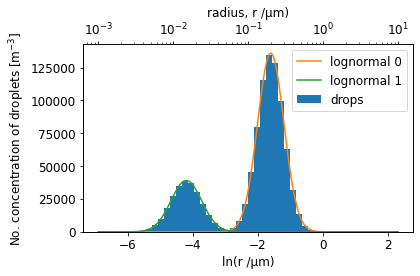

In [8]:
# initialise droplets
for d in range(len(mus)):
    
    mu, sig, n_a = mus[d], sigs[d], n_as[d]
    lnr1, lnnorm1, wdths1, edgs1 = get_lnr_dist(rspan, nbins, n_a, mu, sig)
    r01 = np.e**lnr1
    eps1 = [int(n) for n in lnnorm1*wdths1]
    m_sol1 = rho_sol*4/3*np.pi*r01**3                          # assuming initially dry areosol droplets

    if d==0:
        r0, eps, m_sol = r01, eps1, m_sol1
    else:                        
        r0 = np.concatenate([r0, r01])
        eps = eps+eps1
        m_sol = np.concatenate([m_sol, m_sol1])

        
print('Initial Droplet Distribution:\n')
fig, ax = plt.subplots(figsize=(6,4))
plot_histogram(ax, r0, eps, rspan, nbins, lab='drops', c='C0')          # plot initial distirbution as histogram
for d in range(len(mus)):
    pltlnr, pltnorm, pltwdths = get_lnr_dist(rspan,                     # plot x10 more bins lognormal for reference
                    nbins*10, n_as[d], mus[d], sigs[d])[0:3]
    ax.plot(pltlnr+np.log(1e6), pltnorm*pltwdths*10, 
                     color='C'+str(d+1), label='lognormal '+str(d)) 
raxes4dists(ax, np.log(r01), eps1, edgs1)
ax.legend()
plt.tight_layout()
 
   

In [9]:
### ODE solution
drops = Superdroplets(r0, eps, m_sol,
            mr_sol, ionic, rho_sol, rho_l)                     # drops = object of all droplets in parcel

atol = atol[:-1]+[atol[-1]]*len(r0)
args = [w, drops]
y0 = [z0, temp0, p0, qv0, qc0]
y0.extend(list(drops.r))
sol = solve_ivp(rising_parcel, tspan, 
                y0, method=method, t_eval=t_eval, args=args,
                   max_step=maxtstep, rtol=rtol, atol=atol)    

In [10]:
time = sol.t
z, temp, p, qv, qc = sol.y[:5]
r = sol.y[5:]
theta = dry_pot_temp(temp, p, qv)

print(z.shape, temp.shape, p.shape)
print(qv.shape, qc.shape, r.shape)

### other parcel thermodynamic variables
dry_adia = temp0*(p/p0)**(rgas_dry/cp_dry)
dry_adia_theta = dry_adia*(p0/p)**(rgas_dry/cp_dry)
pv = qv*p/(mr_ratio + qv) 
psat = saturation_pressure(temp)
relh = pv/psat
qsat = mr_ratio * psat/(p-pv) 
s = qv/qsat - 1        

(100,) (100,) (100,)
(100,) (100,) (100, 100)


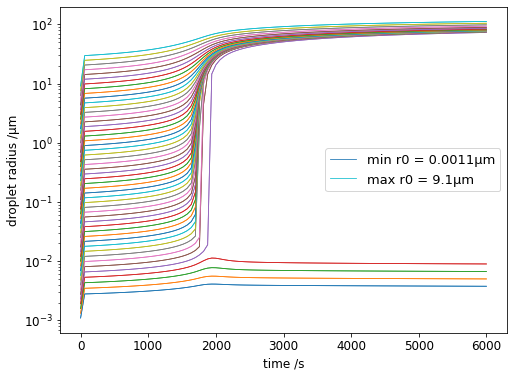

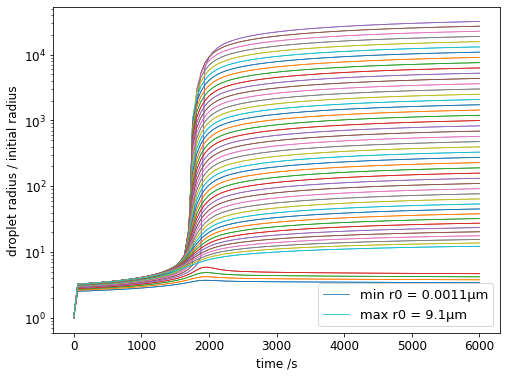

In [11]:
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(8,6))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in drops.r0]
for i in range(len(r)):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == len(r)-1:
        label = 'max r0 = '+labs[i]
    ax.plot(time, r[i]*1e6, linewidth=0.8, label=label)
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius /\u03BCm')
ax.set_yscale('log')
ax.legend(fontsize=13)

fig, ax = plt.subplots(figsize=(8,6))
#cols = ['b','g','r','c','m','y','k']
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
labs2 = [None]*len(r0)
for i in range(len(r)):    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == len(r)-1:
        label = 'max r0 = '+labs[i]
    ax.plot(time, r[i]/r[i,0], linewidth=0.8, label=label) #,color=cols[i])
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius / initial radius')
ax.set_yscale('log')
ax.legend(fontsize=13)

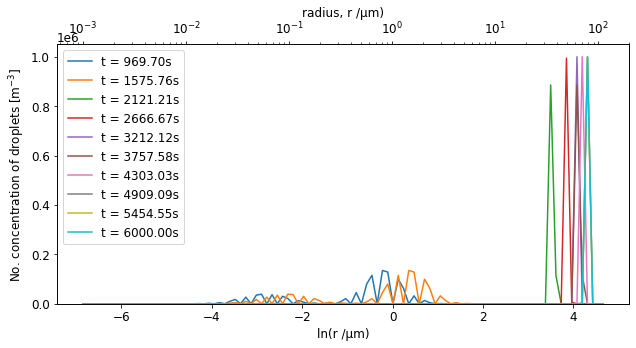

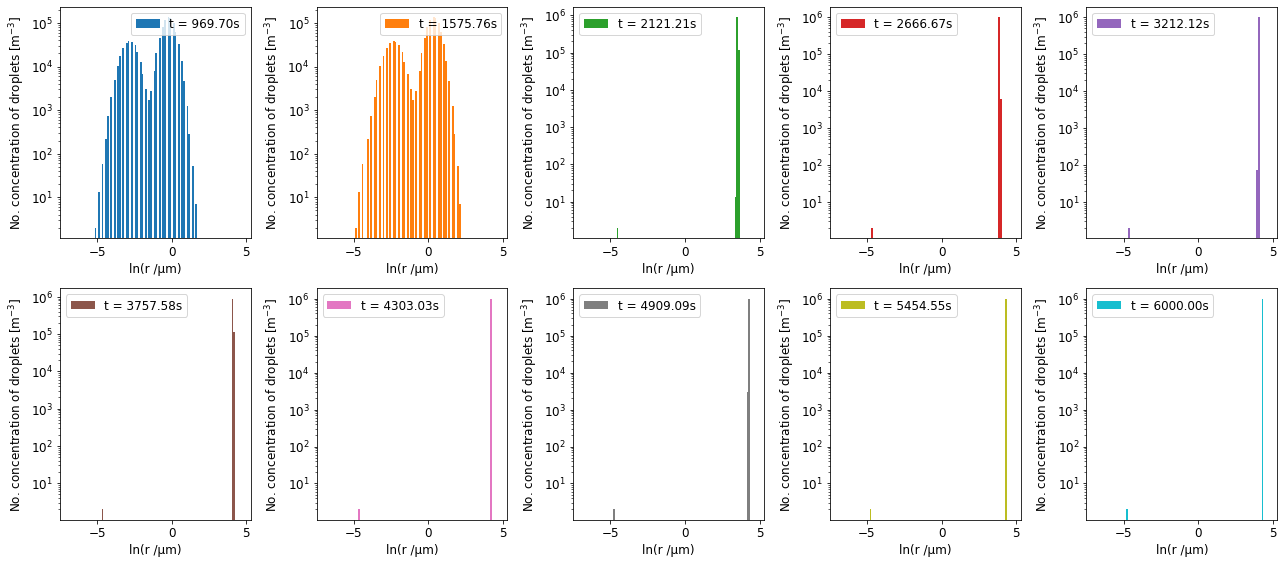

In [12]:


fig, ax = plt.subplots(figsize=(9,5))
nplts = 10
hbins = 100 #no. of histogram bins
rspan = [rspan[0], np.amax(r)]
#tplt = np.linspace(tspan[0], tspan[1], nplts)
tplt = np.linspace(1000, tspan[1], nplts)
for i in range(nplts):
    ind = np.argmin(abs(time-tplt[i]))
    tlab = 't = {:.2f}s'.format(time[ind])
    c = 'C'+str(i)
    hist, wdths, lnr, hedgs = radii2dist(r[:,ind], drops.eps, rspan, hbins)
    ax.plot(lnr+np.log(1e6), hist, label=tlab)
ax, ax1 = raxes4dists(ax, lnr, hist, hedgs)
#ax.set_yscale('log')
ax.legend()
plt.tight_layout()
 

fig, axs = plt.subplots(nrows=2, ncols=nplts//2, figsize=(18,8))
axs = axs.flatten()
for i in range(nplts):
    ind = np.argmin(abs(time-tplt[i]))
    tlab = 't = {:.2f}s'.format(time[ind])
    c = 'C'+str(i) 
    plot_histogram(axs[i], r[:,ind], drops.eps, rspan, hbins, tlab, c)  
    axs[i].set_yscale('log')
plt.tight_layout()




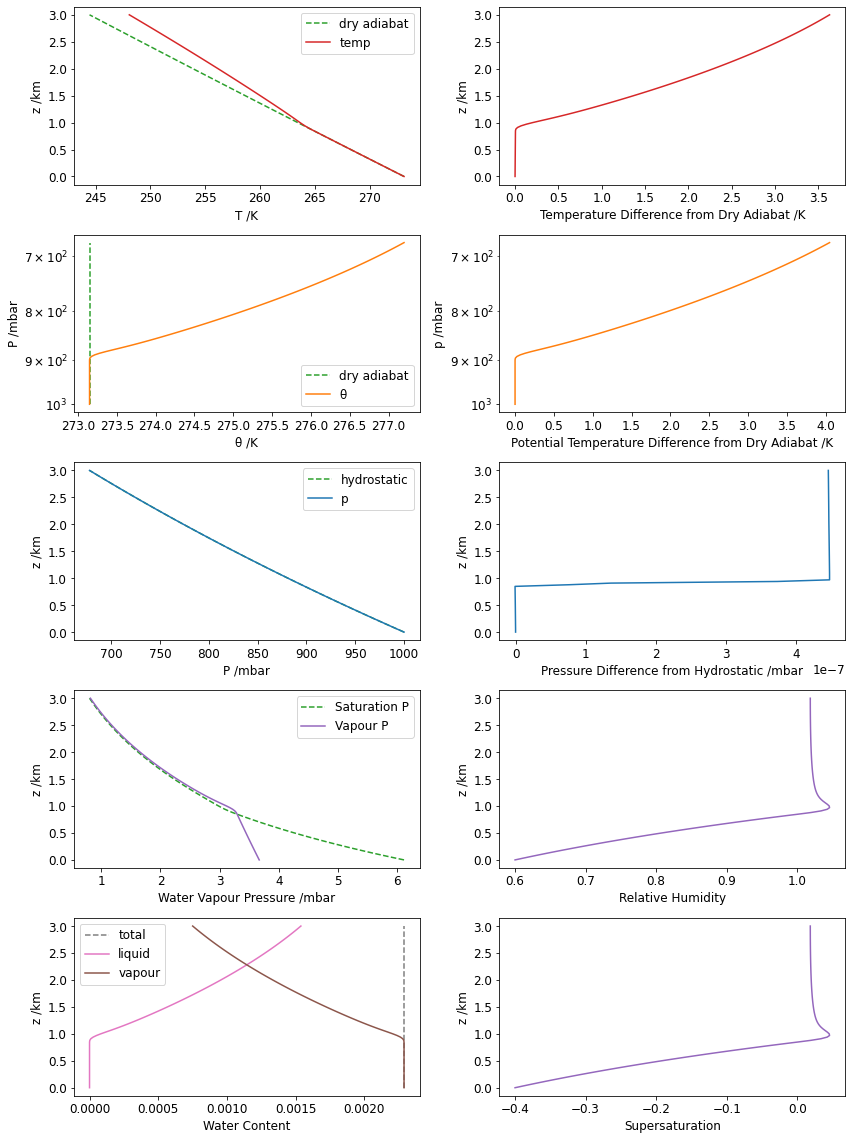

In [13]:
### plots of z, Temp, theta and pressure profiles

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,16))
axs = axs.flatten()

def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    ax.plot(x,y, label=lab, color='C'+str(c), linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axplt(axs[0], dry_adia, z/1000, lab='dry adiabat', c=2, l='--')
axplt(axs[4], pplt/100, z/1000, lab='hydrostatic', c=2, l='--')
axplt(axs[2], dry_adia_theta, p/100, lab='dry adiabat', c=2, l='--')
axplt(axs[0], temp, z/1000, 'T /K', 'z /km', 'temp', 3)
axplt(axs[4], p/100,z/1000,'P /mbar','z /km', 'p', 0)
axplt(axs[2], theta, p/100,'\u03B8 /K','P /mbar', '\u03B8', 1)
axplt(axs[6], psat/100, z/1000,lab='Saturation P', c=2, l='--')
axplt(axs[6], pv/100, z/1000, 'Water Vapour Pressure /mbar','z /km', 'Vapour P', c=4)
axplt(axs[8], qv+qc, z/1000, lab='total', c=7, l='--')
axplt(axs[8], qc, z/1000, lab='liquid', c=6)
axplt(axs[8], qv, z/1000, 'Water Content','z /km', 'vapour', c=5)

axplt(axs[1], temp-dry_adia, z/1000, 
      'Temperature Difference from Dry Adiabat /K', 'z /km', c=3)
axplt(axs[5], (p-pplt)/100, z/1000, 
      'Pressure Difference from Hydrostatic /mbar', 'z /km', c=0)
axplt(axs[3], (theta-dry_adia_theta), p/100, 
      'Potential Temperature Difference from Dry Adiabat /K', 'p /mbar', c=1)
axplt(axs[7], pv/psat, z/1000, 
      'Relative Humidity' ,'z /km', c=4)
axplt(axs[9], s, z/1000, 
      'Supersaturation' ,'z /km', c=4)

for ax in axs[::2]:
    ax.legend()
axs[2].set_yscale('log')
axs[2].invert_yaxis()
axs[3].set_yscale('log')
axs[3].invert_yaxis()


#psat = saturation_pressure(temp)
#axplt(axs[3], psat/100, z/1000,'saturation curve /mbar', 'z /km')

fig.tight_layout()
#plt.close()

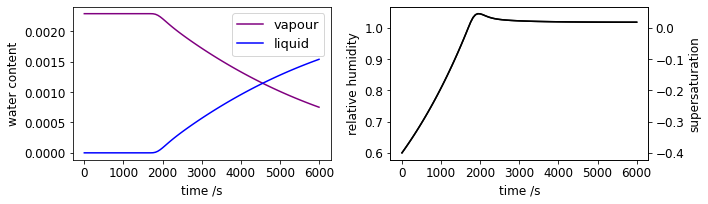

In [14]:
### plots of time evolution of water as parcel rises

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axs2 = axs[1].twinx()

axs[0].plot(time, qv, color='purple', label='vapour')
axs[0].plot(time, qc, color='blue', label='liquid')
axs[1].plot(time, relh, color='k')
axs2.plot(time, s, color='k')
axs[0].set_xlabel('time /s')
axs[0].set_ylabel('water content')
axs[1].set_xlabel('time /s')
axs[1].set_ylabel('relative humidity')
axs2.set_ylabel('supersaturation')
plt.tight_layout()
axs[0].legend(fontsize=13, loc='upper right')
plt.show()

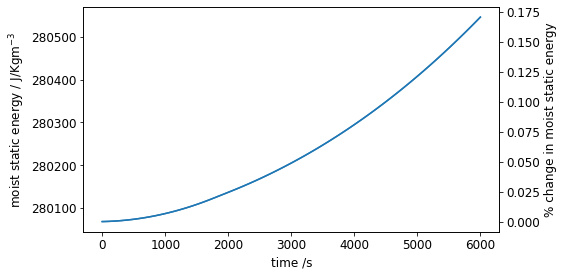

In [15]:
### Moist Static Energy Conservation

def moist_static_energy(z, temp, qv=0):
    ''' calculate the moist static energy /m^3
        (not assuming dry air cp) '''
    
    return  g*z + latent_v*qv + cp_dry*temp


mse = moist_static_energy(z, temp, qv)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(time, mse)
ax1 = ax.twinx()
ax1.plot(time, ((mse-mse[0])/mse[0]*100))
ax.set_ylabel('moist static energy / J/Kgm$^{-3}$')
ax1.set_ylabel('% change in moist static energy')
ax.set_xlabel('time /s')

plt.tight_layout()
plt.show()